# Graph Regression on ESOL dataset


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

# Deep Learning
import torch 
from torch.nn import Linear

#Graph Neaurl Network
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import Dataset
from torch_geometric.loader import  DataLoader

from rdkit import Chem
from rdkit.Chem import PandasTools

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# dataset 
from datasets import EsolDataset    # create a custom dataset for GNNs


. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The dataset

In [2]:
# Load data
df = pd.read_csv('../data/ESOL.csv')
df

,smiles,y
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,CC(C)=CCCC(C)=CC(=O),-2.060
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,c1ccsc1,-1.330
...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,CCSCCSP(=S)(OC)OC,-3.091
1126,CCC(C)C,-3.180


# Descriptive Statistics

## Distribution


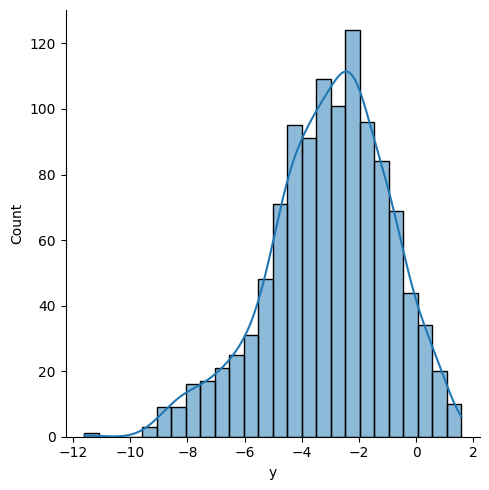

In [3]:
sns.displot(df, x="y", fill=True, kde=True)
#ax.set(xlabel="y")

In [4]:
df.y.describe()

count    1128.000000
mean       -3.050102
std         2.096441
min       -11.600000
25%        -4.317500
50%        -2.860000
75%        -1.600000
max         1.580000
Name: y, dtype: float64

## SMILES
* Simplified Molecular Input Line Entry System (SMILE)

,smiles,y,ROMol
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,
1,Cc1occc1C(=O)Nc2ccccc2,-3.300,
2,CC(C)=CCCC(C)=CC(=O),-2.060,
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,
4,c1ccsc1,-1.330,
...,...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710,
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,
1125,CCSCCSP(=S)(OC)OC,-3.091,
1126,CCC(C)C,-3.180,

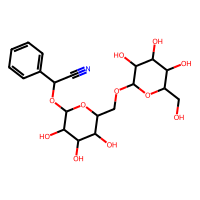
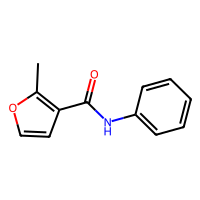
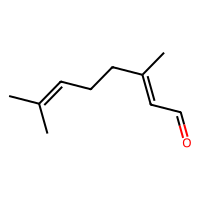
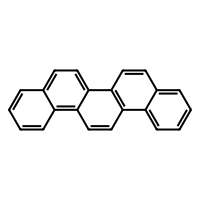
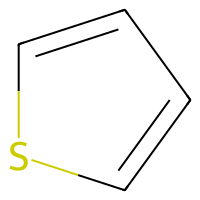
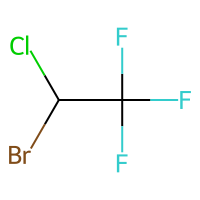
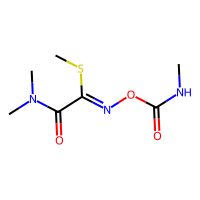
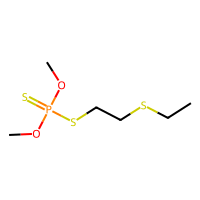
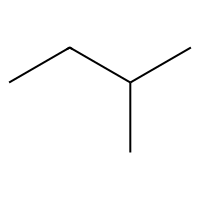
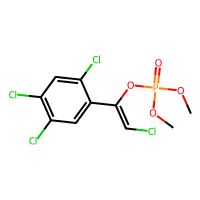

In [5]:
# Adding one column to dataset with visualization 
# source: https://xinhaoli74.github.io/posts/2020/04/RDKit-Cheatsheet/
df_ROMol = df.copy()
PandasTools.AddMoleculeColumnToFrame(df_ROMol, smilesCol='smiles')
df_ROMol


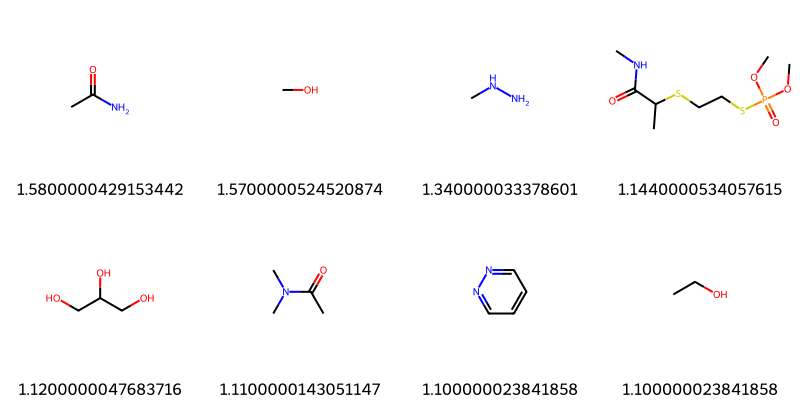

In [6]:
# high values of pKi
PandasTools.FrameToGridImage(df_ROMol.sort_values(by='y', ascending=False).head(8), 
                             legendsCol="y", molsPerRow=4)

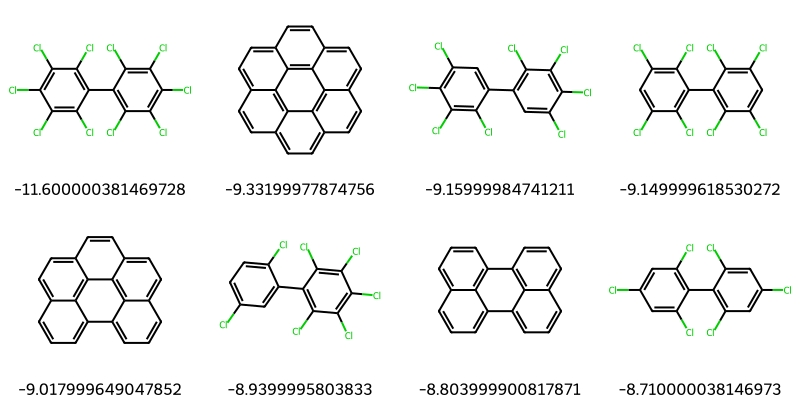

In [7]:
# low values of pKi
PandasTools.FrameToGridImage(df_ROMol.sort_values(by='y', ascending=True).head(8), 
                             legendsCol="y", molsPerRow=4)

## Feature extraction
In this section I'm goint to extract node features from SMILE, using rdkit

In [8]:
def node_features_ave(s):
    '''
    input: SMILE string value
    output: 9 average node features 
    '''
    mol = Chem.MolFromSmiles(s)
    all_node_feats = []
    for atom in mol.GetAtoms():
        node_feats = []
        # Feature 1: Atomic number        
        node_feats.append(atom.GetAtomicNum())
        # Feature 2: Atom degree
        node_feats.append(atom.GetDegree())
        # Feature 3: Formal charge
        node_feats.append(atom.GetFormalCharge())
        # Feature 4: Hybridization
        node_feats.append(atom.GetHybridization())
        # Feature 5: Aromaticity
        node_feats.append(atom.GetIsAromatic())
        # Feature 6: Total Num Hs
        node_feats.append(atom.GetTotalNumHs())
        # Feature 7: Radical Electrons
        node_feats.append(atom.GetNumRadicalElectrons())
        # Feature 8: In Ring
        node_feats.append(atom.IsInRing())
        # Feature 9: Chirality
        node_feats.append(atom.GetChiralTag())

        # Append node features to matrix
        all_node_feats.append(node_feats)

    all_node_feats = np.asarray(all_node_feats)
    return np.asarray(all_node_feats).mean(axis=0).tolist()

In [9]:
# example 
s1 = df['smiles'].iloc[1]
s1

'Cc1occc1C(=O)Nc2ccccc2'

In [10]:
# features exmpales
print('Length:', len(node_features_ave(s1)))
node_features_ave(s1)

Length: 9


[6.333333333333333,
 2.1333333333333333,
 0.0,
 3.066666666666667,
 0.7333333333333333,
 0.7333333333333333,
 0.0,
 0.7333333333333333,
 0.0]

# Models 

## Machine Learning

In [11]:
# Function to extract feactures for machine learning models
def features_ml(data_name):
    file_train = "../data/raw/" + data_name + "_train.csv"
    file_test = "../data/raw/" + data_name + "_test.csv"
    
    df_train = pd.read_csv(file_train)
    df_test = pd.read_csv(file_test)
    
    # Adding averages node features : train 
    lst = [node_features_ave(i) for i in df_train.smiles]
    list_features_name = ['atom_num', 'atom_degree', 'charge', 'hybridization', 'aromaticity',
                               'total_num_hs', 'radical_electrons', 'in_ring', 'chirality']
    df_train = pd.concat([df_train, pd.DataFrame(lst, columns = list_features_name)],axis=1) 

    # Adding averages node features : test 
    lst = [node_features_ave(i) for i in df_test.smiles]
    list_features_name = ['atom_num', 'atom_degree', 'charge', 'hybridization', 'aromaticity',
                               'total_num_hs', 'radical_electrons', 'in_ring', 'chirality']
    df_test =  pd.concat([df_test, pd.DataFrame(lst, columns = list_features_name)],axis=1) 
    
    # set X and y 
    X_train = df_train[list_features_name].to_numpy()
    y_train = df_train['y'].to_numpy()

    X_test = df_test[list_features_name].to_numpy()
    y_test = df_test['y'].to_numpy()
    
    return  X_train, X_test, y_train, y_test

# Train and test machine learning models
def train_test_ml(data, model='LR'):
    # tran and test data
    X_train, X_test, y_train, y_test = data
    if model == 'LR':  # linear regression
        reg = LinearRegression()
    elif model == 'KNN':
        reg = KNeighborsRegressor(n_neighbors=5)
    # Estimation 
    model_reg = reg.fit(X_train, y_train)
    # Predictions
    model_pred = model_reg.predict(X_test)
    
    df_eval_ml = pd.DataFrame()
    df_eval_ml["y"] = y_test.tolist()
    df_eval_ml["y_pred"] = model_pred.tolist()
    
    return df_eval_ml

In [12]:
# Run ML model for each dataset 
list_data = ['ESOL']
model_ml = ['LR', 'KNN']
for mo in model_ml:
    for idx, d in enumerate(list_data):
        print('Model:', mo, ', Dataset:', d)
        data = features_ml(d)
        if idx==0 and mo=='LR':
            df_results_ml = train_test_ml(data, mo)
            df_results_ml['dataset'] = d
            df_results_ml['Model'] = mo
        else:
            df_results_ml1 = train_test_ml(data, mo)
            df_results_ml1['dataset'] = d
            df_results_ml1['Model'] = mo
            df_results_ml = pd.concat([df_results_ml, df_results_ml1], ignore_index=True)
df_results_ml

Model: LR , Dataset: ESOL
Model: KNN , Dataset: ESOL


,y,y_pred,dataset,Model
0,-0.770,-3.515292,ESOL,LR
1,-2.060,-2.567215,ESOL,LR
2,-7.320,-3.841842,ESOL,LR
3,-5.030,-4.571078,ESOL,LR
4,-2.350,-3.062081,ESOL,LR
...,...,...,...,...
487,-0.400,-0.356000,ESOL,KNN
488,-3.610,-5.420400,ESOL,KNN
489,-3.451,-3.625800,ESOL,KNN
490,-2.380,-1.696000,ESOL,KNN


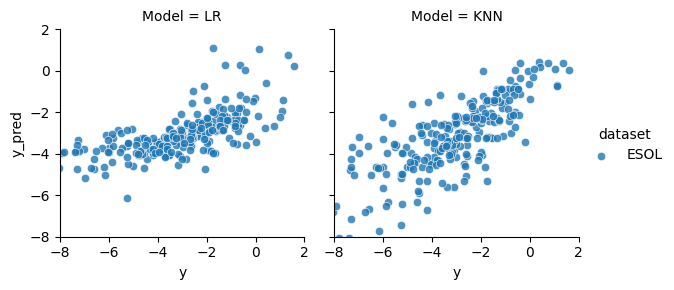

In [13]:
# Plot by model
g = sns.FacetGrid(df_results_ml, col="Model", hue="dataset", ylim =(-8, 2), xlim =(-8, 2))
g.map(sns.scatterplot, "y", "y_pred", alpha=0.8)
g.add_legend()


In [14]:
# Get metrics 
model_ml = ['LR', 'KNN']
list_data = ['ESOL']
for mo in model_ml:
    mape_gcn = []
    for idx, d in enumerate(list_data):
        df0 = df_results_ml[(df_results_ml['dataset']==d) & (df_results_ml['Model']==mo)]
        mape = mean_absolute_percentage_error(df0["y"], df0["y_pred"])
        mape_gcn.append(mape)
    if mo=='LR':
         df_final_results = pd.DataFrame({'MAPE':mape_gcn, 'Dataset':list_data, 'Model': mo})
    else:
        df_final_results1 = pd.DataFrame({'MAPE':mape_gcn, 'Dataset':list_data, 'Model': mo})
        df_final_results = pd.concat([df_final_results, df_final_results1], ignore_index=True)
df_final_results

,MAPE,Dataset,Model
0,1.692255,ESOL,LR
1,0.834982,ESOL,KNN


## Graph Neural Networks (GNNs)

### Convolutional GNN, GCN (Kipf and Welling, ICLR'17 )
* GCN models help with the spatial representation of a molecular


Other mothels 
- Attention GNN
- Message-passing GNN

In [15]:
# model
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        self.num_features = 9  # data.num_features
        self.embedding_size = 64
        
        # GCN layers
        self.initial_conv = GCNConv(self.num_features, self.embedding_size)
        self.conv1 = GCNConv(self.embedding_size, self.embedding_size)
        self.conv2 = GCNConv(self.embedding_size, self.embedding_size)
        self.conv3 = GCNConv(self.embedding_size, self.embedding_size)
        self.conv4 = GCNConv(self.embedding_size, self.embedding_size)

        # Output layer
        self.out = Linear(self.embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = torch.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv4(hidden, edge_index)
        hidden = torch.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out.view(-1), hidden
# train 
def train(loader, model, loss_fn, optimizer, device):
    # Enumerate over the data
    for batch in loader:
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 

        # Passing the node features and the connection info
        pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
        # Calculating the loss and gradients
        loss = loss_fn(pred, batch.y)     
        loss.backward()  
        # Update using the gradients
        optimizer.step()   
        return loss, embedding

# run train and test, save the predictions
def train_test(model, data_train, data_test, epochs=500):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Los mean squared error
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

    # Wrap data in a data loader
    loader = DataLoader(data_train, batch_size=32, shuffle=True)

    print("Starting training...")
    losses = []
    for epoch in range(epochs):
        loss, h = train(loader, model, loss_fn, optimizer, device)
        losses.append(loss)
        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Train Loss {loss}")

    # predictions 
    test_loader = DataLoader(data_test, batch_size=len(data_test))
    test_batch = next(iter(test_loader))
    with torch.no_grad():
        test_batch.to(device)
        pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
        df_eval_GCN = pd.DataFrame()
        df_eval_GCN["y"] = test_batch.y.tolist()
        df_eval_GCN["y_pred"] = pred.tolist()
        
    return df_eval_GCN

In [16]:
# Example of datasets with all the input information for graph model
df_train = EsolDataset(root="../data/", filename="ESOL_train.csv", test=False)

# Investigating the dataset
print("Dataset type: ", type(df_train))
print("Dataset features: ", df_train.num_features)
print("Dataset target: ", df_train.num_classes)
print("Dataset length: ", df_train.len)
print("Dataset sample: ", df_train[0])
print("Sample  nodes: ", df_train[0].num_nodes)
print("Sample  edges: ", df_train[0].num_edges)

# remove temporal datasets
shutil.rmtree('../data/processed/')

Processing...
100%|███████████████████████████████████████████████████████████████████████████████| 882/882 [00:01<00:00, 877.38it/s]
Done!


Dataset type:  <class 'datasets.EsolDataset'>
Dataset features:  9
Dataset target:  628
Dataset length:  <bound method EsolDataset.len of EsolDataset(882)>
Dataset sample:  Data(x=[15, 9], edge_index=[2, 32], edge_attr=[32, 2], y=[1], smiles='Cc1occc1C(=O)Nc2ccccc2')
Sample  nodes:  15
Sample  edges:  32


In [17]:
# Run GCN model 
list_data = ['ESOL']
for idx, d in enumerate(list_data):
    print('Kinase:', d)
    file_train = d + "_train.csv"
    file_test = d + "_test.csv"
    df_train = EsolDataset(root="../data/", filename=file_train, test=False)
    df_test = EsolDataset(root="../data/", filename=file_test, test=True)
    
    model = GCN()
    if idx==0:
        df_results_gcn = train_test(model, df_train, df_test, epochs=3000)
        df_results_gcn['Dataset'] = d
    else:
        df_results_gcn1 = train_test(model, df_train, df_test, epochs=3000)
        df_results_gcn1['Dataset'] = d
        df_results_gcn = pd.concat([df_results_gcn, df_results_gcn1], ignore_index=True)

    # remove temporal datasets
    shutil.rmtree('../data/processed/')


Processing...


Kinase: ESOL


100%|███████████████████████████████████████████████████████████████████████████████| 882/882 [00:01<00:00, 774.06it/s]
Done!
Processing...
100%|███████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 793.19it/s]
Done!


Starting training...
Epoch 0 | Train Loss 13.726154327392578
Epoch 500 | Train Loss 3.9282686710357666
Epoch 1000 | Train Loss 1.8294343948364258
Epoch 1500 | Train Loss 1.1409354209899902
Epoch 2000 | Train Loss 0.6364138722419739
Epoch 2500 | Train Loss 0.5560230016708374


In [18]:
# Results from GCN model
df_results_gcn

,y,y_pred,Dataset
0,-0.770,-1.420676,ESOL
1,-2.060,-1.680186,ESOL
2,-7.320,-4.902707,ESOL
3,-5.030,-4.226511,ESOL
4,-2.350,-1.979155,ESOL
...,...,...,...
241,-0.400,-0.462882,ESOL
242,-3.610,-3.616413,ESOL
243,-3.451,-4.321972,ESOL
244,-2.380,-1.739304,ESOL


<AxesSubplot: xlabel='y', ylabel='y_pred'>

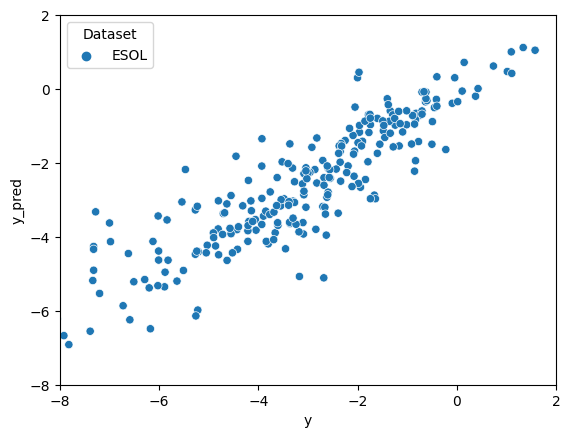

In [19]:
# plot 
plt = sns.scatterplot(data=df_results_gcn, x="y", y="y_pred", hue="Dataset")
plt.set(xlim=(-8, 2))
plt.set(ylim=(-8, 2))
plt

In [20]:
# Get metrics
list_data = ['ESOL']
mape_gcn = []
for idx, d in enumerate(list_data):
    df0 = df_results_gcn[df_results_gcn['Dataset']==d]
    mape = mean_absolute_percentage_error(df0["y"], df0["y_pred"])
    mape_gcn.append(mape)

df_final_results1 = pd.DataFrame({'MAPE':mape_gcn, 'Dataset':list_data, 'Model': 'GNNs'})
df_final_results1

,MAPE,Dataset,Model
0,0.473268,ESOL,GNNs


In [21]:
# Concatenate all results 
df_final_results = pd.concat([df_final_results, df_final_results1], ignore_index=True)
df_final_results

,MAPE,Dataset,Model
0,1.692255,ESOL,LR
1,0.834982,ESOL,KNN
2,0.473268,ESOL,GNNs


<AxesSubplot: xlabel='Dataset', ylabel='MAPE'>

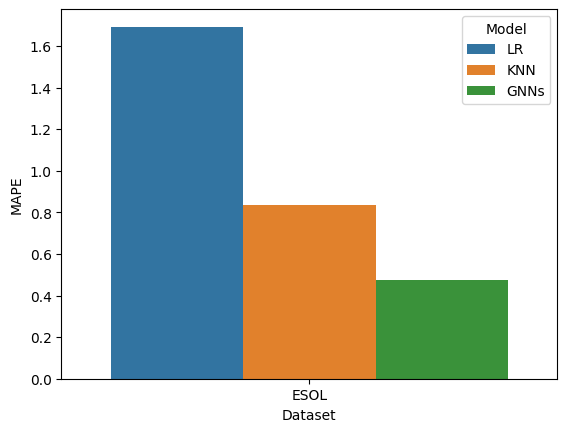

In [22]:
# Plot and save final results 
sns.barplot(data=df_final_results, x="Dataset", y="MAPE", hue="Model")